# Characterize within-host variants

May 8, 2020

Kat and Gage have sequenced SARS-CoV2 from putative transmission pairs in Wisconsin. In this data, they see that there is a lot of shared within-host diversity between pairs, but that a lot of this diversity is also shared among non-transmission pairs of samples. This is concerning and a little weird. This was also observed in [this paper](https://www.medrxiv.org/content/10.1101/2020.04.24.20078691v1) that Gage found, although I have not read it closely. 

There are a few questions that I think would be nice to try to address by looking at the phylogeny: 

1. Are any of these recurrent within-host mutations also ones identified as problematic/likely errors by people looking at consensus data? If so, these should probably be excluded. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)

2. How frequently do within-host variants appear in consensus sequences? I would hypothesize that the vast majority of within-host variation being generated is not particularly advantageous. In this scenario, we would expect to observe only a small fraction of these within-host variants on the phylogeny, and when we do, we expect them to be primarily observed at terminal nodes rather than on internal branches.

3. Do any of these within-host variants appear downstream at the consensus level from the host they were sampled in? By this I mean, if we observe a within-host variant in a particular person, is that infection upstream of later sampled cases? If so, is that variant detected at consensus level in any of those offspring infections? We will see. 


I think that for this analysis, it may be worthwhile to try to help them set up a Wisconsin-focused community build. This could use the new snakemake rules to generate a community build that focuses on Wisconsin but also pulls in sequences from elsewhere. This might be a nice thing to help facilitate and it would absolutely provide them with a better tree for inference than their current Wisconsin-only build. 

Kat mapped the genomes to this reference: MN908947.3.

This is a link to their local nextstrain build http://35.226.31.45/Wisconsin?branchLabel=aa&c=clade_membership&r=location

One note here is that indels are labelled differently in Kat's output files than in the nextstrain tree. In the nextstrain tree, `-505A` means that there was an A insertion at 505. `A505-` means that there was a deletion at 505. 

### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import requests
import pandas as pd 
import numpy as np
    
import rpy2
%load_ext rpy2.ipython

In [2]:
pd.set_option('display.max_columns', 35)

In [3]:
# define which column we want to use to look at variants. Use 'nuc_muts' to characterize variants relative to the 
# Wuhan 1 reference, or 'minor_nuc_muts' to do a consensus-agnostic comparison
variant_column = 'minor_nuc_muts'
frequency_column = 'minor_frequency'

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [4]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [5]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [6]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; I am going to exclude tube 127, USA/WI-UW-118/2020
# which has >50 indels and >50 SNVs. It has a pretty high Ct as well, so I think these are probably errors 
# as it is a very clear outlier
# remove 302, 303, 304, 302, 735, and 736 because these are time-series! 
samples_to_ignore = ["N_transcript","127","302","303","304","735","736"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, all_intersection_variants,metadata_dict, strain_names_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

In [7]:
twist_sites = snvs_only[snvs_only['sampleid'] == "twist_rna"]['POS_x'].tolist()
print(twist_sites)

[3350.0, 6669.0, 8853.0, 9164.0, 26791.0, 26793.0, 26796.0]


In [8]:
all_original_strains = snvs_only['strain_name'].tolist()
all_original_strains = list(set(all_original_strains))
print(len(all_original_strains))

132


In [9]:
"""remove all rows containing variants at twist sites"""
snvs_only = snvs_only[~snvs_only['POS_x'].isin(twist_sites)]

In [10]:
all_strains = snvs_only['strain_name'].tolist()
all_strains = list(set(all_strains))
print(len(all_strains))
#print(set(all_strains))

131


In [11]:
"""print out the strains we have dropped by excluding twist sites"""
for s in all_original_strains:
    if s not in all_strains: 
        print(s)

USA/twist_rna_control/2020


In [12]:
"""subset data to include only SNVs and indels >3% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] >= float(variant_percent)]
# indels_only = indels_only[indels_only[frequency_column] >= float(variant_percent)]

"""subset data to include only SNVs and indels <50% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] <= float(0.5)]
# indels_only = indels_only[indels_only[frequency_column] <= float(0.5)]

In [13]:
strain_names_dict2 = {}
for s in strain_names_dict:
    tubeid = s
    strain_name = strain_names_dict[s]
    strain_names_dict2[strain_name] = tubeid

In [14]:
"""print out the strains we've dropped based on our frequency filtering criteria"""
all_strains_with_variants = snvs_only['strain_name'].tolist()
all_strains_with_variants = list(set(all_strains_with_variants))

samples_with_no_variants = 0
for s in all_strains:
    if s not in all_strains_with_variants: 
        print(strain_names_dict2[s], s)
        samples_with_no_variants += 1
        
print(samples_with_no_variants)
print(len(all_strains_with_variants))

74 USA/WI-UW-84/2020
32 USA/WI-UW-52/2020
182 USA/IL-UW-149/2020
1293 USA/WI-UW-861/2020
61 USA/WI-UW-74/2020
388 USA/WI-UW-296/2020
887 USA/WI-UW-546/2020
1353 USA/WI-UW-895/2020
20 USA/WI-UW-41/2020
1328 USA/WI-UW-876/2020
145 USA/WI-UW-124/2020
277 USA/WI-UW-232/2020
31 USA/WI-UW-51/2020
197 USA/WI-UW-160/2020
24P USA/WI-UW-21/2020
1297 USA/WI-UW-863/2020
158 USA/WI-UW-132/2020
283 USA/WI-UW-238/2020
289 USA/WI-UW-243/2020
128 USA/WI-UW-119/2020
5 USA/WI-UW-29/2020
21
110


In [15]:
#snvs_only.to_csv("/Users/lmoncla/src/ncov-WI-within-host/data/all-WI-snvs.tsv", sep="\t")
snvs_only.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,consensus_aa,minor_aa,minor_nuc_muts,minor_aa_muts
0,0,CHRSTART-orf1ab_241C>T_intergenic,241.0,0.9590,0.9723,0.96565,95,CHRSTART-orf1ab,241C>T,intergenic,intergenic_region,USA/WI-UW-97/2020,Dane County,20A,adjacent,a,snv,erge,NA,nic,C,T,C241T,0.03435,T,C,nic,NA,T241C,CHRSTART-orf1ab_nicergeNA
1,1,orf1ab_1299T>C_Cys433Cys_synonymous,1564.0,0.0819,0.0452,0.06355,95,orf1ab,1299T>C,Cys433Cys,synonymous,USA/WI-UW-97/2020,Dane County,20A,not,[],snv,433,Cys,Cys,T,C,T1564C,0.06355,T,C,Cys,Cys,T1564C,orf1ab_Cys433Cys
2,2,orf1ab_2772C>T_Phe924Phe_synonymous,3037.0,0.9122,0.9237,0.91795,95,orf1ab,2772C>T,Phe924Phe,synonymous,USA/WI-UW-97/2020,Dane County,20A,not,[],snv,924,Phe,Phe,C,T,C3037T,0.08205,T,C,Phe,Phe,T3037C,orf1ab_Phe924Phe
3,3,orf1ab_7586C>T_Ala2529Val_missense,7851.0,0.0846,0.0476,0.06610,95,orf1ab,7586C>T,Ala2529Val,missense,USA/WI-UW-97/2020,Dane County,20A,adjacent,a,snv,2529,Ala,Val,C,T,C7851T,0.06610,C,T,Ala,Val,C7851T,orf1ab_Ala2529Val
4,4,orf1ab_11152G>T_Val3718Phe_missense,11417.0,0.9558,0.9544,0.95510,95,orf1ab,11152G>T,Val3718Phe,missense,USA/WI-UW-97/2020,Dane County,20A,not,[],snv,3718,Val,Phe,G,T,G11417T,0.04490,T,G,Phe,Val,T11417G,orf1ab_Phe3718Val


In [16]:
snvs_only.columns

Index(['Unnamed: 0', 'SNP', 'POS_x', 'rep1_percent', 'rep2_percent',
       'frequency', 'sampleid', 'gene', 'nt_change', 'aa_change', 'annotation',
       'strain_name', 'location', 'clade', 'homopolymer', 'homopolymer_base',
       'type_of_variant', 'aa_site', 'wt_aa', 'mut_aa', 'nt_ref', 'nt_mut',
       'nuc_muts', 'minor_frequency', 'consensus_base', 'minor_base',
       'consensus_aa', 'minor_aa', 'minor_nuc_muts', 'minor_aa_muts'],
      dtype='object')

In [17]:
print(set(snvs_only['annotation'].tolist()))
# print(set(indels_only['annotation'].tolist()))

{'intergenic', 'intergenic_region', 'stop', 'missense', 'synonymous'}


In [21]:
snvs_to_query = set(snvs_only[variant_column].dropna().tolist())
print(len(snvs_to_query))
print("\ntotal samples with a variant:")
print(len(set(snvs_only['strain_name'].tolist())))

184

total samples with a variant:
110


## How many variants are there per sample?

On average, and a distribution

In [25]:
"""output number of SNVs per sample. This will output the mean and stdev for whatever input you give it. So if 
you input all variants, including consensus level ones, that is what you will get out"""

def return_number_variants_per_sample(df):

    snvs_dict = {}
    snvs_list = []
    total_snvs = 0
    
    print("printing samples with >15 variants")
    print("strain name\tnumber variants\t sample id")
    for i in set(df['strain_name'].tolist()):
        x = df[df['strain_name'] == i]
        snvs_dict[i] = [len(x)]
        snvs_list.append(len(x))
        total_snvs += len(x)
        sampleid = list(set(x['sampleid'].tolist()))[0]
        
        if len(x) >= 15:
            print(i, len(x), sampleid)
    
    mean_number_snvs = total_snvs/(len(snvs_list))
    nparray = np.asarray(snvs_list)
    stdev = nparray.std()
    median = np.median(nparray)
    percentile_95 = np.percentile(nparray,97.5)
    percentile_5 = np.percentile(nparray,2.5)
    max_snvs = max(snvs_list)
    min_snvs = min(snvs_list)
    print("mean and st dev: ",mean_number_snvs, stdev)
    print("median: ", median)
    print("95th percentile: ",percentile_5,percentile_95)
    print("max:",max_snvs, "min:",min_snvs)
    print(len(snvs_list))
    
    return(snvs_dict)

In [26]:
print("snvs")
snvs_dict = return_number_variants_per_sample(snvs_only)

snvs
printing samples with >15 variants
strain name	number variants	 sample id
mean and st dev:  3.481818181818182 2.5574554761318313
median:  3.0
95th percentile:  1.0 10.0
max: 11 min: 1
110


In [27]:
# convert to dataframes and combine
snvs_per_sample_df = pd.DataFrame.from_dict(snvs_dict, orient="index")
snvs_per_sample_df.reset_index(inplace=True)
snvs_per_sample_df.columns = ['strain','SNVs']
# indels_per_sample_df = pd.DataFrame.from_dict(indels_dict, orient="index")
# indels_per_sample_df.reset_index(inplace=True)
# indels_per_sample_df.columns = ['strain','indels']

# variants_per_sample_df = snvs_per_sample_df.merge(indels_per_sample_df, on='strain', how='outer')
# variants_per_sample_df = variants_per_sample_df.fillna(0)
# variants_per_sample_df['variants'] = variants_per_sample_df['SNVs'] + variants_per_sample_df['indels']
# variants_per_sample_df.head()

In [36]:
# convert to counts of number of samples that have x SNVs
snv_counts = pd.DataFrame(snvs_per_sample_df['SNVs'].value_counts())
snv_counts.reset_index(inplace=True)
snv_counts.columns = ['number_of_SNVs','number_of_samples']

# indel_counts = pd.DataFrame(variants_per_sample_df['indels'].value_counts())
# indel_counts.reset_index(inplace=True)
# indel_counts.columns = ['number_of_indels','number_of_samples']

# variant_counts = pd.DataFrame(variants_per_sample_df['variants'].value_counts())
# variant_counts.reset_index(inplace=True)
# variant_counts.columns = ['number_of_variants','number_of_samples']
# variant_counts.head()


In [37]:
"""add in a row for the samples without any variants; 21 represents the ones with only fixed variants"""
zero_counts = pd.DataFrame([[0,21]], columns=['number_of_SNVs','number_of_samples'])
snv_counts = snv_counts.append(zero_counts)
snv_counts.head()

,number_of_SNVs,number_of_samples
0,1,33
1,2,18
2,3,15
3,5,11
4,4,10


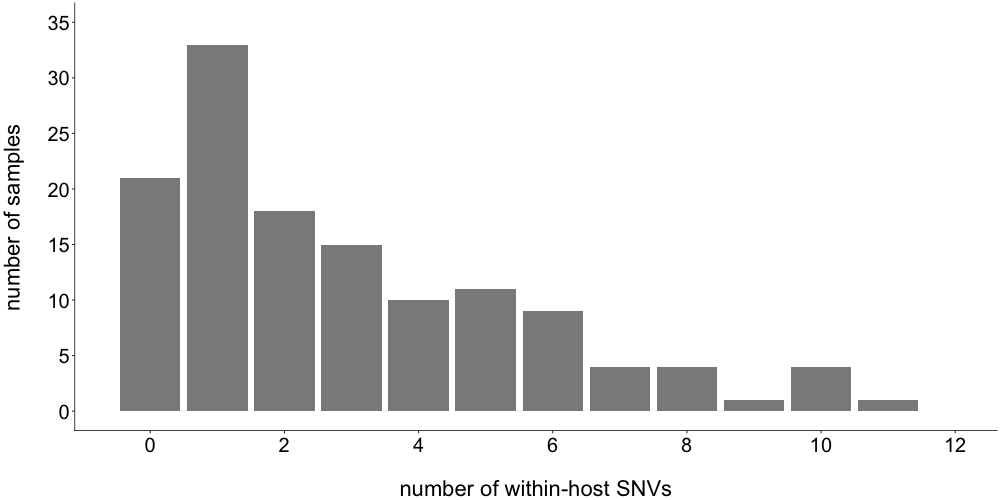

In [38]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,snv_counts # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)


output_filename = paste("SNVs-per-sample-",variant_percent,"percent-",current_date,".pdf", sep="")

p1 <- ggplot(snv_counts, aes(x=number_of_SNVs, y=number_of_samples))+
    geom_col(fill="#8B8B8B")+
    #scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,35), breaks=seq(0,35,5))+
    scale_x_continuous(breaks=seq(0,12,2), limits=c(-0.5,12))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=22, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=22, vjust=0.5))+
    theme(axis.text.y=element_text(size=20, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, vjust=0.5, size=20, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nnumber of within-host SNVs",y="number of samples\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p1, width = 6, height = 4, path="../figures/individual-pdfs/")
p1